# Exercise 1: Your First Inference with SBI

**Time:** 15 minutes  
**Goal:** Run neural posterior estimation on the Lotka-Volterra predator-prey model

## 🎯 Learning Objectives

By the end of this exercise, you will:
1. Set up a simulator for SBI
2. Define a prior over parameters
3. Train a neural posterior estimator
4. Visualize and interpret the posterior distribution

---

## 📖 The Story

You're a data scientist for a regional environmental agency. The farmers and hunters
south of Krakow have collected a dataset of daily counts of wolves and deers. However,
due to data privacy issues, the data team cannot give these daily counts to you
directly. Instead, you receive summary statistics of the data: for now only the mean,
std, max, kurtosis and skew for each population over a span of 200 days.

These summary statistics are your only window into the ecosystem's health.

**Your mission:** Use these sparse summary statistics to infer the continuous-time
dynamics of the predator-prey relationship and predict how the populations might evolve
in the future.


## Step 1: Import and Setup

First, let's import everything we need:

In [1]:
# Core imports
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from sbi import utils as utils

# SBI imports
from sbi.inference import NPE, simulate_for_sbi

# Tutorial-specific imports
from simulators.lotka_volterra import (
    create_lotka_volterra_prior,
    generate_observed_data,
    get_summary_labels,
    lotka_volterra_simulator,
    simulate,
)
from utils import (
    generate_posterior_predictive_simulations,
    plot_posterior_predictions,
    print_summary_statistics,
    analyze_posterior_statistics,
)

# Set style for nice plots
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 16

/Users/janteusen/qode/euroscipy-2025-sbi-tutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42  # For reproducibility
np.random.seed(seed)
torch.manual_seed(seed)

# 🔧 CONFIGURATION: Toggle this to see the impact of different summary statistics
USE_AUTOCORRELATION = True  # Set to True to include temporal dynamics

# Simulation settings
num_simulations = 20_000
# TODO: Adjust number of workers based on your system.
num_workers = 10

print("✅ Simulator ready! Let's analyze deer-wolf dynamics in southern Poland.")

✅ Simulator ready! Let's analyze deer-wolf dynamics in southern Poland.


## Step 2: Load the Observed Data

Let's load and visualize the population statistics that your field team collected from the forests south of Kraków:

In [3]:
# Get the observed data for our scenario.
observed_data, true_params = generate_observed_data(
    use_autocorrelation=USE_AUTOCORRELATION
)
# Note that true_params would not be available in a real scenario.

# Create a configured simulator that uses our chosen autocorrelation setting
lotka_volterra_simulator = partial(
    lotka_volterra_simulator, use_autocorrelation=USE_AUTOCORRELATION
)

# Get labels and print statistics using utility function
data_labels = get_summary_labels(use_autocorrelation=USE_AUTOCORRELATION)
print_summary_statistics(observed_data, data_labels, USE_AUTOCORRELATION)

🐺🦌 Observed Summary Statistics from Forests South of Kraków:
Deer Mean         : 9.52
Deer Std          : 13.01
Deer Max          : 47.67
Deer Skew         : 1.51
Deer Kurtosis     : 1.03
Deer ACF Lag 10   : 0.97
Deer ACF Lag 50   : 0.73
Deer ACF Lag 100  : 0.36
Deer ACF Lag 200  : -0.16
Deer ACF Lag 400  : -0.33
Wolf Mean         : 6.08
Wolf Std          : 7.08
Wolf Max          : 25.21
Wolf Skew         : 1.08
Wolf Kurtosis     : -0.12
Wolf ACF Lag 10   : 0.97
Wolf ACF Lag 50   : 0.76
Wolf ACF Lag 100  : 0.37
Wolf ACF Lag 200  : -0.12
Wolf ACF Lag 400  : -0.33

📈 Total summary statistics: 20

❓ Question: What birth and death rates could produce these population patterns?
💡 We have rich temporal information - this should enable good long-term predictions!


## Step 3: Define the Prior

Before we can infer parameters, we need to specify our prior beliefs about reasonable parameter ranges.

The Lotka-Volterra model has 4 parameters:
- **α**: Deer birth rate (how fast deer reproduce)
- **β**: Predation rate (how efficiently wolves hunt deer)  
- **δ**: Wolf efficiency (how well wolves convert deer to offspring)
- **γ**: Wolf death rate (natural wolf mortality)

Based on ecological knowledge from Polish forests, we set uniform priors over plausible ranges:

In [4]:
# We use our expert domain knowledge to set uniform prior boundaries.
prior = create_lotka_volterra_prior()

# Sample a few parameter sets to see the prior
print("\n🎲 Example parameter samples from prior:")
prior_samples = prior.sample((3,))
for i, sample in enumerate(prior_samples):
    print(
        f"  Sample {i + 1}: α={sample[0]:.2f}, β={sample[1]:.3f}, δ={sample[2]:.3f}, γ={sample[3]:.2f}"
    )


🎲 Example parameter samples from prior:
  Sample 1: α=0.12, β=0.029, δ=0.012, γ=0.06
  Sample 2: α=0.12, β=0.010, δ=0.007, γ=0.12
  Sample 3: α=0.09, β=0.023, δ=0.029, γ=0.07


## Step 4: The Magic - Neural Posterior Estimation in 5 Lines! ✨

Now comes the exciting part. With just a few lines of code, we'll:
1. Create a neural posterior estimator
2. Generate training simulations
3. Train the neural network
4. Get the posterior distribution

Watch how simple this is:

In [5]:
# THE 5 LINES OF SBI! 🚀

# Line 1: Create the inference object
npe = NPE(prior)

# Line 2: Generate training data (this might take ~30 seconds)
print("🔄 Generating training simulations...")
theta, x = simulate_for_sbi(
    lotka_volterra_simulator,
    prior,
    num_simulations=num_simulations,
    num_workers=num_workers,
)
print(f"✅ Generated {len(theta)} simulations")

# Line 3: Train the neural network (this might take ~1 minute)
print("\n🧠 Training neural posterior estimator...")
npe.append_simulations(theta, x).train()
print("✅ Training complete!")

# Line 4: Build posterior for our observed data
posterior = npe.build_posterior()

# Line 5: Sample from the posterior
print("\n📈 Sampling from posterior...")
posterior_samples: torch.Tensor = posterior.sample((10000,), x=observed_data)  # type: ignore
print(f"✅ Drew {len(posterior_samples)} posterior samples")

print("\n🎉 Inference complete! Let's see what we learned...")

🔄 Generating training simulations...


100%|██████████| 20000/20000 [00:28<00:00, 701.27it/s]


✅ Generated 20000 simulations

🧠 Training neural posterior estimator...
 Neural network successfully converged after 220 epochs.✅ Training complete!

📈 Sampling from posterior...


Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 72116.77it/s]

✅ Drew 10000 posterior samples

🎉 Inference complete! Let's see what we learned...


In [6]:
# Let's save the posterior for later.
filename = f"lv_inference{'_autocorr' if USE_AUTOCORRELATION else ''}.pt"
with open(filename, "wb") as handle:
    pickle.dump(npe, handle)

/var/folders/8b/twrk9drd50l015by37329_7m0000gn/T/ipykernel_74930/664847599.py:4: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(npe, handle)


## Step 5: Visualize the Results

Now let's see what the neural network learned about the parameters:

/var/folders/8b/twrk9drd50l015by37329_7m0000gn/T/ipykernel_74930/1719538164.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors', 'points_kwargs', 'labels_params', 'ticks_params'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig = pairplot(


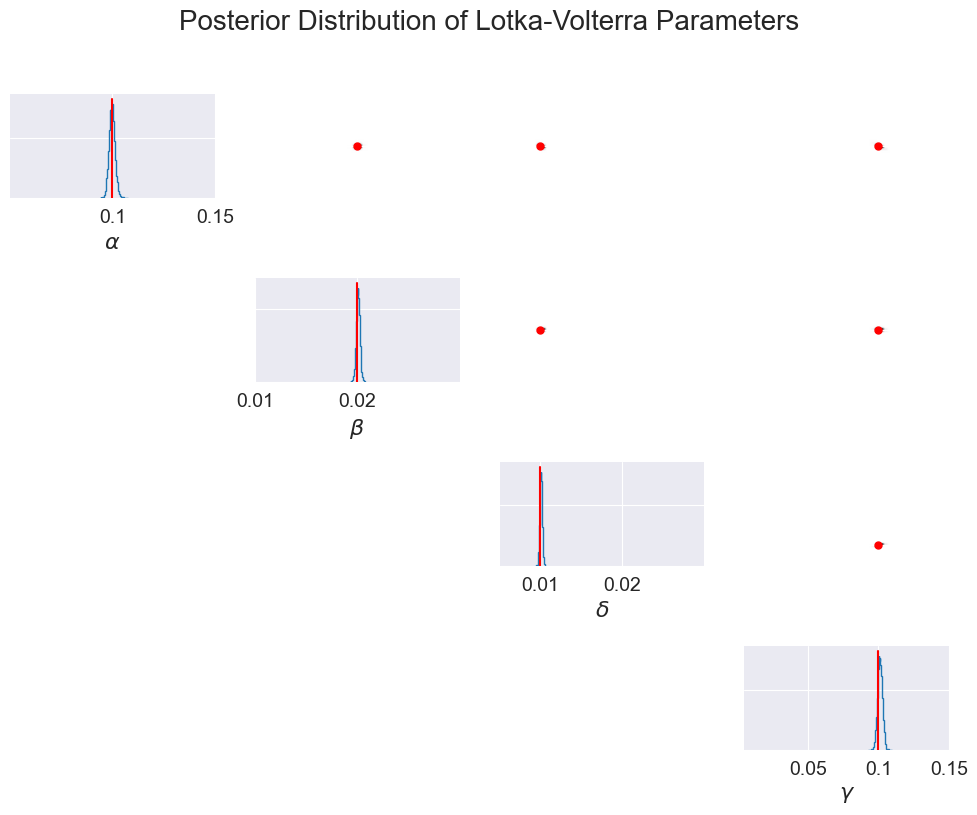

In [7]:
# Plot the posterior distributions
from sbi.analysis import pairplot

fig = pairplot(
    posterior_samples,
    points=true_params,
    labels=[r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"],
    figsize=(10, 8),
    points_colors="red",
    points_kwargs={"s": 100, "marker": "*", "label": "True parameters"},
    labels_params={"fontsize": 5},
    ticks_params={"labelsize": 14},
    # use prior limits
    limits=[
        (low, high)
        for (low, high) in zip(prior.base_dist.low, prior.base_dist.high, strict=False)
    ],
)

plt.suptitle("Posterior Distribution of Lotka-Volterra Parameters", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## Step 6: Interpret the Results

Let's extract key statistics from our posterior:

In [8]:
# Define parameter names for our Lotka-Volterra model
param_names = [
    "α (deer birth)",
    "β (predation)",
    "δ (wolf efficiency)",
    "γ (wolf death)",
]

# Use our minimal function to analyze posterior statistics
posterior_stats = analyze_posterior_statistics(
    posterior_samples=posterior_samples,
    param_names=param_names,
    true_params=true_params,
)

📊 Posterior Statistics
Parameter            Mean ± Std           Median          95% CI              
----------------------------------------------------------------------
α (deer birth)       0.100 ± 0.001        0.100           [0.097, 0.103]      
β (predation)        0.020 ± 0.000        0.020           [0.020, 0.020]      
δ (wolf efficiency)  0.010 ± 0.000        0.010           [0.010, 0.010]      
γ (wolf death)       0.101 ± 0.002        0.101           [0.098, 0.104]      

🎯 True Parameters (for comparison):
✅ α (deer birth)       0.100 (in 95% CI: True)
✅ β (predation)        0.020 (in 95% CI: True)
✅ δ (wolf efficiency)  0.010 (in 95% CI: True)
✅ γ (wolf death)       0.100 (in 95% CI: True)

🔗 Parameter Correlations:
α vs β           : +0.169
α vs δ           : -0.803
α vs γ           : -0.880
β vs δ           : +0.160
β vs γ           : -0.102
δ vs γ           : +0.892


## 💡 Key Insights About Posterior Correlations

The above 1D and 2D marginals of the posterior distribution are relatively broad,
indicating that we can observe same data patterns across different parameters. This
happens because:

1. **Parameter Compensation**: Changing one parameter can be compensated by adjusting
   another, and vice versa
2. **Identifiability Challenges**: Multiple parameter combinations can produce similar
   summary statistics
3. **Statistical Grounding**: These correlations are statistically principled, which
   would be difficult to achieve with optimization alone

Understanding these correlations helps us:
- Identify which parameters are most constrained by the data
- Recognize when additional data or different summary statistics might be needed
- Interpret the biological meaning of parameter trade-offs in the ecosystem model

## Step 7: Predict Future Population Dynamics

Now for the most impactful part of our analysis. We have inferred the hidden parameters
of the ecosystem from just a few summary numbers. Can we use this to predict how the
deer and wolf populations will evolve over the weeks?

Yes! We can take parameter sets from our posterior, run the full simulation forward in
time for each of them, and visualize the results. This will give us a **distribution of
possible futures**, complete with uncertainty bands.

The plotting function below will draw 1000 posterior samples, calculate the median
samples and the maximum of the posterior (Maximum a Posterior estimate, MAP), and
simulate all those parameters with the LV simulator without calculating summary
statistics (using the entire time series over 200 days). This shows our prediction of
how the wolve and deer populations will evolve and it will inform political decisions.


Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 54545.86it/s]


Plotting posterior predictive time series...


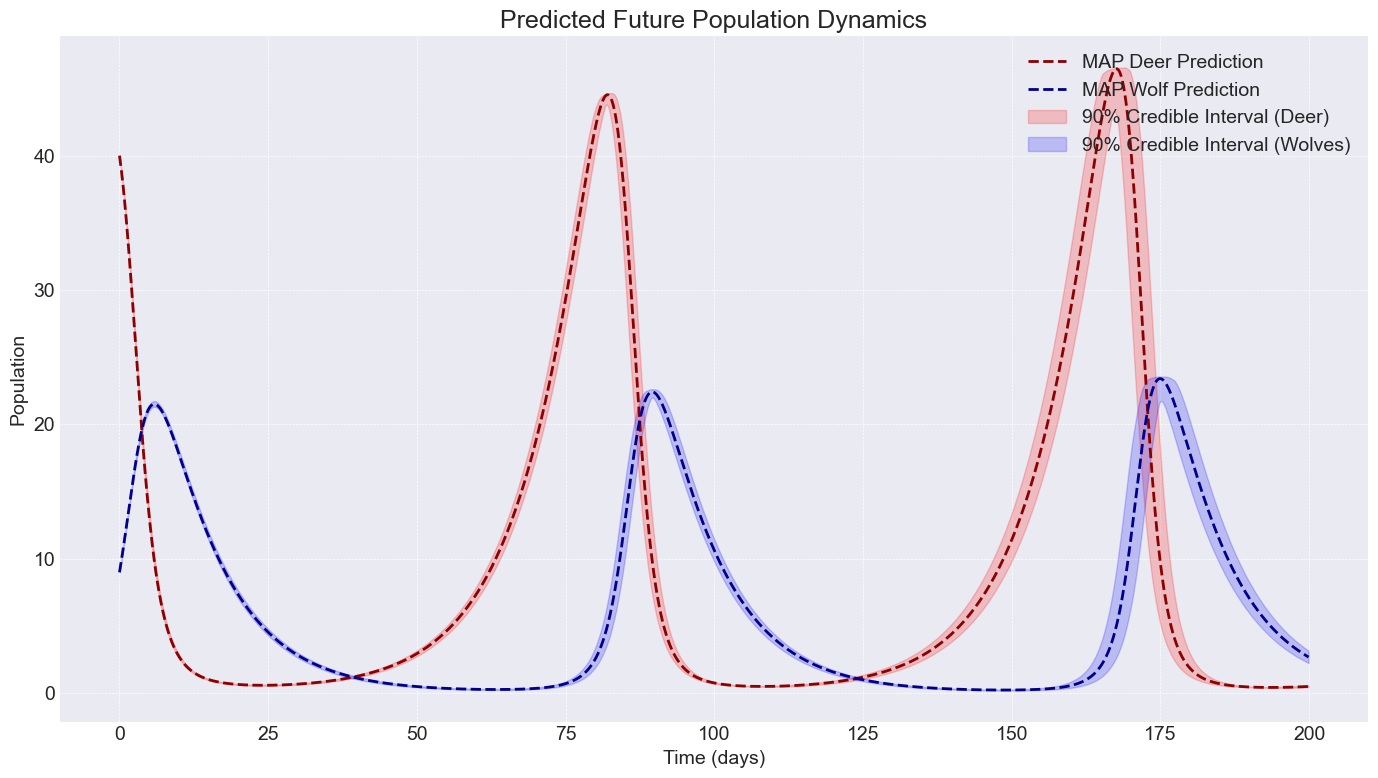

In [9]:
# Generate posterior predictive simulations and MAP simulation
map_simulation, predictive_simulations = generate_posterior_predictive_simulations(
    posterior=posterior,
    observed_data=observed_data,
    simulate_func=simulate,
    prior=prior,
    num_simulations=1000,
    num_workers=10,
)

# Plot the results using our utility function
fig, ax = plot_posterior_predictions(
    predictions=predictive_simulations,
    map_prediction=map_simulation,
)

## 🚀 Optional Exercise: Improving Predictions with Better Statistics

**Scenario:** After presenting your results, the farmers and hunters were concerned about the high uncertainty in your predictions, especially how quickly the confidence intervals grow after just a few weeks. They need more reliable forecasts for planning their wildlife management strategies.

You explain that better predictions require more informative data. After some negotiation, the data team agrees to provide additional temporal information: **5 autocorrelation lags** for each population, capturing how current population levels relate to past levels.

**Your Task:** 
1. Set `USE_AUTOCORRELATION = True` in the configuration cell above
2. Re-run the analysis from Step 2 onwards
3. Compare the new results with your previous analysis

**Questions to explore:**
- How do the posterior distributions change with more informative statistics?
- How does the prediction uncertainty compare between the two approaches?
- What does this tell us about the value of temporal information in ecological modeling?

**Hint:** You'll need to restart from the data generation step since the summary statistics will be different!

**Expected outcome:** You should see much tighter posterior distributions and significantly reduced uncertainty in long-term predictions, demonstrating the power of informative summary statistics in SBI!

## 🎯 Key Takeaways

Congratulations! You've just completed your first SBI analysis. Here's what you accomplished:

1.  **Inference from summaries**: We inferred the parameters of a complex time-series model using only a few summary statistics, mimicking a real-world scenario of sparse data.
2.  **Full time-series prediction**: We used the posterior to generate not just summary predictions, but full, high-resolution forecasts of future population dynamics.
3.  **Powerful uncertainty quantification**: We didn't just get a single future trajectory; we generated a distribution of possible futures, complete with credible intervals that show how uncertainty grows over time.
4.  **Bridging data gaps**: This workflow shows how to move from sparse, aggregated data (monthly reports) to rich, actionable insights (continuous population forecasts).

### 🌲 Applications to Environmental Management

This kind of analysis is incredibly valuable for decision-making:
-   **Proactive Policy**: Instead of reacting to population crashes, the agency can see potential futures and act preemptively.
-   **Risk Assessment**: The width of the credible intervals quantifies the range of plausible outcomes, helping to assess best-case and worst-case scenarios.
-   **Resource Allocation**: Understanding the likely trajectories helps in planning conservation efforts, such as habitat restoration or intervention measures.

### ⚠️ Important Questions

Before we trust these results for forest management decisions, we should ask:
1. Is the neural network approximation accurate?
2. Would different summary statistics give us better inference?
3. How many simulations do we really need?
4. Are we losing important information by summarizing?

**→ These questions are addressed in Exercise 2: Diagnostics!**


In [10]:
# Space for experimentation
